0. Imports

In [53]:
import numpy as np
import os, glob, json
from typing import Tuple, Iterable
from multiprocessing import Pool, Process
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import time
import random
from random import shuffle
from sklearn.manifold import TSNE
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix

1. Load 10 second data (50 per class)

In [9]:
def getJsonFileNamesInFolder(path2jsonFiles: str) -> Iterable[str]:
    res = glob.glob(path2jsonFiles)
    return res

def parseJsonFile(filename: str, track_dict: dict) -> dict:
    # start_t = time.perf_counter()
    file = open(filename)
    content = json.load(file)
    #print(content)

    label = content["label"]
    #print(content["label"])
    if label not in track_dict:
        track_dict[label] = 0
    
    track_dict[label] = track_dict[label] + 1
    #print("number of ", label, track_dict[label])

    file.close()
    # end_t = time.perf_counter()
    return content, track_dict

def parseJsonFiles(filenames: Iterable[str], maximumNumberOfFilesPerLabel = -1) -> dict:
    start_t = time.perf_counter()
    track_dict: dict = dict()



    results = []
    #print("parseJsonFiles", filenames)
    #print("type filenames", type(filenames))

    shuffle(filenames)
    filenames_shuffled = filenames


    #print("shuffled_filenames", filenames_shuffled)

    # with Pool() as pool:
    #     results = pool.map(parseJsonFile, filenames)
    
    for filename in filenames_shuffled:
        #print("filename", filename)
        temp,track_dict = parseJsonFile(filename, track_dict)
        
        if(maximumNumberOfFilesPerLabel == -1):
            results.append(temp)

        if(track_dict[temp["label"]] <= maximumNumberOfFilesPerLabel):
            results.append(temp)

        if(len(track_dict.keys()) == 9):
            doBreak = True
            for key in track_dict:
                if track_dict[key] < maximumNumberOfFilesPerLabel:
                    doBreak = False
            if(doBreak):
                break # break as soon as each class has reached the maximum number of datapoints

        # for filename, content, duration in results:
        #     print(f"{filename} completed in {duration:.2f}s")
    end_t = time.perf_counter()
    total_duration = end_t - start_t
    print(f"etl took {total_duration:.2f}s total")
    return results

def createXandY(path2jsonFiles: str, maximumNumberOfFilesPerLabel = -1) -> Tuple[np.ndarray, np.ndarray]:
    # (filename, dict)
    jsonFilePaths : str = getJsonFileNamesInFolder(path2jsonFiles)
    print(jsonFilePaths)
    parsedFilesList = parseJsonFiles(jsonFilePaths, maximumNumberOfFilesPerLabel=maximumNumberOfFilesPerLabel)
    
    numberOfFiles = int(len(parsedFilesList))

    

    print(type(parsedFilesList[0]))
    
    
    
    sampleRate = int(parsedFilesList[0]["sampleRate"])
    durationInSeconds = int(parsedFilesList[0]["durationInSeconds"])
    datapointsPerChannel = sampleRate*durationInSeconds
    numberOfChannels = 3

    X = np.empty((numberOfFiles,datapointsPerChannel, numberOfChannels)) # (numberOfFiles, sampleRate*durationInSeconds, numberOfChannels)
    y = np.empty((numberOfFiles,),dtype=object) #(numberOfFiles, 1)

    for idx, parsedFile in enumerate(parsedFilesList):
        
        X_temp = np.empty((datapointsPerChannel, numberOfChannels))
        
        X_temp[:,0] = parsedFile["x"]
        X_temp[:,1] = parsedFile["y"]
        X_temp[:,2] = parsedFile["z"]

        X[idx] = X_temp

        y[idx] = parsedFile["label"]



    print("X:", X.shape, "y:", y.shape)
    return X,y 




In [11]:
X, y = createXandY("../data/traintest/*.json", maximumNumberOfFilesPerLabel=100)
X_eval, y_eval = createXandY("../data/evaluation/*.json", maximumNumberOfFilesPerLabel=100)

['../data/traintest/1661470457342_to_1661470578339_shape_40000_4_sampleRate_4000_durationInSeconds_10.json', '../data/traintest/1662041197516_to_1662466208815_shape_40000_4_sampleRate_4000_durationInSeconds_10.json', '../data/traintest/1663261204154_to_1663261325151_shape_40000_4_sampleRate_4000_durationInSeconds_10.json', '../data/traintest/1661436286942_to_1661436553639_shape_40000_4_sampleRate_4000_durationInSeconds_10.json', '../data/traintest/1663249043654_to_1663249164651_shape_40000_4_sampleRate_4000_durationInSeconds_10.json', '../data/traintest/1662653424850_to_1662653545847_shape_40000_4_sampleRate_4000_durationInSeconds_10.json', '../data/traintest/1661492346242_to_1661492467239_shape_40000_4_sampleRate_4000_durationInSeconds_10.json', '../data/traintest/1662483197218_to_1662483318215_shape_40000_4_sampleRate_4000_durationInSeconds_10.json', '../data/traintest/1663065600966_to_1663065721963_shape_40000_4_sampleRate_4000_durationInSeconds_10.json', '../data/traintest/16625606

2. Remove outliers

In [13]:
def deleteOutliers(X, y):
    badIndices = findIllogicalValues(X, threshold=100)

    X = np.delete(X, badIndices, axis=0)
    y = np.delete(y, badIndices, axis=0)
    print("X:", X.shape, "y:", y.shape)
    return X, y
    

def findIllogicalValues(arr,threshold):    
    indices = []
    
    for idx, recording in enumerate(arr):
        flag = False
        for datapoint in recording: 
            for i, channel in enumerate(datapoint):                
                temp = channel
                if (abs(temp) > threshold):                    
                    flag = True
        if(flag):
            indices.append(idx)
    return indices

In [14]:
X, y = deleteOutliers(X, y)
X_eval, y_eval = deleteOutliers(X_eval, y_eval)

X: (897, 40000, 3) y: (897,)
X: (405, 40000, 3) y: (405,)


3. Apply low-pass filter

In [15]:
import numpy as np
from scipy import signal
def applyLowPassFilter(X):
    # set the filter parameters
    fs = 4000  # sampling frequency in Hz
    fc = 1100  # cutoff frequency in Hz
    order = 4  # filter order

    # calculate the filter coefficients
    b, a = signal.butter(order, fc / (fs / 2), 'low')

    # apply the filter to each recording of acceleration data
    filtered_accel_data = np.zeros_like(X)

    for i in range(X.shape[0]):
        filtered_accel_data[i,:,:] = signal.filtfilt(b, a, X[i,:,:], axis=0)
    print("X:", X.shape)
    return filtered_accel_data

In [16]:
X = applyLowPassFilter(X)
X_eval = applyLowPassFilter(X_eval)

X: (897, 40000, 3)
X: (405, 40000, 3)


4. feature engineering => extract features based on the everywhereml-library's second order

In [20]:
import numpy as np
from scipy.stats import skew, kurtosis

def extract_features(accel_data):
    # Initialize the result array with zeros
    num_recordings = accel_data.shape[0]
    num_axes = 3
    num_features = 20
    features = np.zeros((num_recordings, num_axes, num_features))

    # Calculate the features for each axis and recording separately
    for recording in range(num_recordings):
        recording_data = accel_data[recording]

        for axis in range(num_axes):
            axis_data = recording_data[:, axis]

            max_value = np.max(axis_data)
            min_value = np.min(axis_data)
            abs_max_value = np.max(np.abs(axis_data))
            abs_min_value = np.min(np.abs(axis_data))
            mean_value = np.mean(axis_data)
            abs_energy_value = np.sum(np.square(axis_data))
            mean_abs_change_value = np.mean(np.abs(np.diff(axis_data)))
            cid_ce_value = np.sum(np.abs(np.diff(axis_data))) / (np.sum(np.abs(axis_data)) + 1e-9)
            std_value = np.std(axis_data)
            var_value = np.var(axis_data)
            count_above_mean_value = np.sum(axis_data > mean_value)
            count_below_mean_value = np.sum(axis_data < mean_value)
            first_position_of_max_value = np.argmax(axis_data)
            first_position_of_min_value = np.argmin(axis_data)
            max_count_value = np.sum(axis_data == max_value)
            min_count_value = np.sum(axis_data == min_value)
            has_large_std_value = int(std_value > np.percentile(axis_data, 95))
            skew_value = skew(axis_data)
            kurtosis_value = kurtosis(axis_data)
            variation_coefficient_value = np.std(axis_data) / np.mean(axis_data)

            # Add the features to the result array
            features[recording, axis] = np.array([
                max_value, min_value, abs_max_value, abs_min_value, mean_value,
                abs_energy_value, mean_abs_change_value, cid_ce_value, std_value,
                var_value, count_above_mean_value, count_below_mean_value,
                first_position_of_max_value, first_position_of_min_value,
                max_count_value, min_count_value, has_large_std_value, skew_value,
                kurtosis_value, variation_coefficient_value
            ])

    # Combine the features for all three axes
    features = features.reshape(num_recordings, -1)

    # Return the features as a NumPy array
    return features

In [23]:
Xf = extract_features(X)
Xf_eval = extract_features(X_eval)

4.5 One-Hot encoder

In [73]:
np.unique(y)

array(['GLT_Rollwagen', 'Gehen', 'HebenSenken', 'Hubwagen', 'Kiste liegt',
       'Rollenbahn', 'Rolltisch', 'Sackkarre', 'vert. drehen'],
      dtype=object)

In [74]:
np.unique(y_eval)

array(['GLT_Rollwagen', 'Gehen', 'HebenSenken', 'Hubwagen', 'Kiste liegt',
       'Rollenbahn', 'Rolltisch', 'Sackkarre', 'vert. drehen'],
      dtype=object)

In [83]:
enc = OneHotEncoder(handle_unknown='ignore')
enc.fit(y.reshape(-1,1))

OneHotEncoder(handle_unknown='ignore')

In [84]:
enc.transform([["vert. drehen"]]).toarray()

array([[0., 0., 0., 0., 0., 0., 0., 0., 1.]])

In [85]:
yf=y#enc.transform(y.reshape(-1,1)).toarray()
yf_eval = y_eval#enc.transform(y_eval.reshape(-1,1)).toarray()

5. Create the train-test-split (30%)

In [86]:
X_train, X_test, y_train, y_test = train_test_split(Xf, yf, stratify=yf, test_size=0.3, random_state=42)

6. Train (RandomForest-) Classifier [AutoML]

In [113]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.metrics import f1_score

In [114]:
def eval_metrics(actual, pred):
    rmse = np.sqrt(mean_squared_error(actual, pred))
    mae = mean_absolute_error(actual, pred)
    r2 = r2_score(actual, pred)
    return rmse, mae, r2

In [87]:
clf = RandomForestClassifier(n_estimators=20, max_depth=20, n_jobs=-1)

In [88]:
clf.fit(X_train, y_train)

RandomForestClassifier(max_depth=20, n_estimators=20, n_jobs=-1)

In [89]:
clf.score(X_test, y_test)

0.9851851851851852

In [90]:
clf.classes_

array(['GLT_Rollwagen', 'Gehen', 'HebenSenken', 'Hubwagen', 'Kiste liegt',
       'Rollenbahn', 'Rolltisch', 'Sackkarre', 'vert. drehen'],
      dtype=object)

In [91]:
clfx = RandomForestClassifier(n_estimators=20, max_depth=20, n_jobs=-1)
clfx.fit(Xf, yf)

RandomForestClassifier(max_depth=20, n_estimators=20, n_jobs=-1)

In [92]:
clfx.score(Xf_eval, yf_eval)

0.9728395061728395

In [118]:
import mlflow

In [127]:
bestF1_score = -1
bestModel = None

In [140]:
n_jobs = -1


def run_model(n_estimators, max_depth, max_features, bestF1_score, bestModel):
    with mlflow.start_run(run_name="find the best RandomForestClassifier for [d10r4000]") as run:
        max_features = max_features +1

        clfx_opt = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth, n_jobs=n_jobs, max_features=max_features)
        clfx_opt.fit(Xf, yf)
        predicted_labels = clfx_opt.predict(Xf_eval)
        
        y_true = yf_eval
        y_pred = predicted_labels

        # (rmse, mae, r2)= eval_metrics(y_true, y_pred)
        # print((rmse, mae, r2))
        f1_score_macro = f1_score(y_true, y_pred, average='macro')

        if(f1_score_macro > bestF1_score):
            bestF1_score = f1_score_macro
            bestModel = clfx

        print(n_estimators, max_depth, max_features, "f1_score_macro", f1_score_macro)
        f1_score_micro = f1_score(y_true, y_pred, average='micro')
        f1_score_weighted = f1_score(y_true, y_pred, average='weighted')
        #f1_score_average_none = f1_score(y_true, y_pred, average='None')
        mlflow.log_param("n_estimators", n_estimators)
        mlflow.log_param("max_depth", max_depth)
        mlflow.log_param("n_jobs", n_jobs)
        mlflow.log_param("max_features", max_features)
        # mlflow.log_metric("rmse", rmse)
        # mlflow.log_metric("r2", r2)
        # mlflow.log_metric("mae", mae)

        mlflow.log_metric("f1_score_macro", f1_score_macro)
        mlflow.log_metric("f1_score_micro", f1_score_micro)
        mlflow.log_metric("f1_score_weighted", f1_score_weighted)
        mlflow.log_metric("n_classes_", clfx.n_classes_)
        mlflow.log_metric("n_features_n", clfx.n_features_)
        
        #mlflow.log_metric("f1_score_average_none", f1_score_none)


        mlflow.sklearn.log_model(clfx, "model")
        return (run.info.experiment_id, run.info.run_id, bestF1_score, bestModel)

In [141]:
Xf.shape[1]

60

In [142]:


for n_estimators in np.arange(start=1, stop=22, step=3):
    for max_depth in np.arange(start=1, stop=22, step=3):
        for max_features in np.arange(start=0, stop=Xf.shape[1], step=10):
            _, _, bestF1_score, bestModel = run_model(n_estimators=n_estimators, max_depth=max_depth, max_features=max_features, bestF1_score=bestF1_score, bestModel=bestModel)

1 1 1 f1_score_macro 0.02222222222222222
1 1 11 f1_score_macro 0.11158564669430139
1 1 21 f1_score_macro 0.1358024691358025
1 1 31 f1_score_macro 0.1358024691358025
1 1 41 f1_score_macro 0.13464258513763463
1 1 51 f1_score_macro 0.11843238587424633
1 4 1 f1_score_macro 0.34222236312019594
1 4 11 f1_score_macro 0.4609459404585954
1 4 21 f1_score_macro 0.5028422227204697
1 4 31 f1_score_macro 0.4990969088651886
1 4 41 f1_score_macro 0.43165316797923553
1 4 51 f1_score_macro 0.8227447385672592
1 7 1 f1_score_macro 0.5346793226719521
1 7 11 f1_score_macro 0.6927767840270973
1 7 21 f1_score_macro 0.9801867919845448
1 7 31 f1_score_macro 0.9126373959323507
1 7 41 f1_score_macro 0.8700623949013315
1 7 51 f1_score_macro 0.7875577896303231
1 10 1 f1_score_macro 0.5147211005909643
1 10 11 f1_score_macro 0.8994011222398657
1 10 21 f1_score_macro 0.9655312797716316
1 10 31 f1_score_macro 0.9357047377646628
1 10 41 f1_score_macro 0.9283280055075589
1 10 51 f1_score_macro 0.8724391634924334
1 13 1 f

In [143]:
bestF1_score

0.9925916779849364

7. Evaluate with test data [AutoML]

8. Re-train using train- AND testdata [AutoML]

9. Evaluate with evaluation data [AutoML]

10. Create confusion matrix

In [52]:
import matplotlib.pyplot as plt
import numpy as np

def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    """
    This function plots a confusion matrix.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

In [144]:
# y_pred = enc.inverse_transform(clfx.predict(Xf_eval)).ravel()
# y_true = enc.inverse_transform(yf_eval).ravel()
y_pred = bestModel.predict(Xf_eval)
y_true = yf_eval

In [ ]:
print(y_pred.shape, y_pred[0])
print(y_true.shape[0], y_true[0])

(405,) Gehen
405 Gehen


In [146]:
cm=confusion_matrix(y_true, y_pred, labels=np.unique(y))

Confusion matrix, without normalization


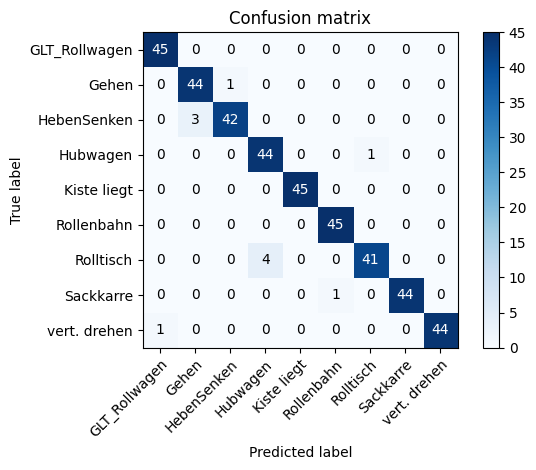

In [153]:
plot_confusion_matrix(cm,classes = np.unique(y),normalize=False)
plt.show()

In [148]:
import pandas as pd

In [149]:
df = pd.DataFrame({'True Label': y_true, 'Predicted Label': y_pred})

In [150]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
    print(df)

        True Label Predicted Label
0            Gehen           Gehen
1      Kiste liegt     Kiste liegt
2      HebenSenken     HebenSenken
3        Sackkarre       Sackkarre
4        Rolltisch       Rolltisch
5        Rolltisch       Rolltisch
6     vert. drehen    vert. drehen
7      Kiste liegt     Kiste liegt
8      Kiste liegt     Kiste liegt
9     vert. drehen    vert. drehen
10      Rollenbahn      Rollenbahn
11      Rollenbahn      Rollenbahn
12        Hubwagen        Hubwagen
13      Rollenbahn      Rollenbahn
14   GLT_Rollwagen   GLT_Rollwagen
15       Sackkarre       Sackkarre
16           Gehen           Gehen
17     HebenSenken           Gehen
18       Rolltisch       Rolltisch
19    vert. drehen    vert. drehen
20        Hubwagen        Hubwagen
21   GLT_Rollwagen   GLT_Rollwagen
22     HebenSenken     HebenSenken
23           Gehen           Gehen
24     Kiste liegt     Kiste liegt
25       Sackkarre       Sackkarre
26     Kiste liegt     Kiste liegt
27     HebenSenken  

In [151]:
!mlflow ui

[2023-03-08 18:14:08 +0000] [461385] [INFO] Starting gunicorn 20.1.0
[2023-03-08 18:14:08 +0000] [461385] [INFO] Listening at: http://127.0.0.1:5000 (461385)
[2023-03-08 18:14:08 +0000] [461385] [INFO] Using worker: sync
[2023-03-08 18:14:08 +0000] [461387] [INFO] Booting worker with pid: 461387
[2023-03-08 18:14:08 +0000] [461388] [INFO] Booting worker with pid: 461388
[2023-03-08 18:14:08 +0000] [461394] [INFO] Booting worker with pid: 461394
[2023-03-08 18:14:08 +0000] [461395] [INFO] Booting worker with pid: 461395
^C
[2023-03-08 18:23:56 +0000] [461385] [INFO] Handling signal: int
[2023-03-08 18:23:57 +0000] [461395] [INFO] Worker exiting (pid: 461395)
[2023-03-08 18:23:57 +0000] [461387] [INFO] Worker exiting (pid: 461387)
[2023-03-08 18:23:57 +0000] [461388] [INFO] Worker exiting (pid: 461388)
[2023-03-08 18:23:57 +0000] [461394] [INFO] Worker exiting (pid: 461394)
